

**Adı:** Fazlı Fatih

**Soyadı:** Bulut

**Okul Numarası:** 2312729007

**GitHub Repo Bağlantısı:** https://github.com/kullanici_adi/genetik_optimizasyonu

---

## Proje Tanımı: Senaryo 7 - Laboratuvarda Numune Karışımı

**Amaç:** Bir biyoteknoloji firması için en verimli test çözeltisini oluşturmak amacıyla reaktif oranlarını optimize etmek.

**Amaç Fonksiyonu (Test Hassasiyeti Puanı):**
$$y = 3x_1 + 2x_2 + x_1x_2 - 0.5x_2^2$$

**Değişkenler:**
* $x_1$: Reaktif A oranı (%) $\rightarrow [10, 80]$
* $x_2$: Reaktif B oranı (%) $\rightarrow [10, 80]$

**Kısıtlar:**
1.  $x_1 + x_2 \le 100$ (Toplam karışım %100'ü geçemez)
2.  $x_1 \ge 25$ (Reaktif A en az %25 olmalıdır)

### 1. Kütüphanelerin Yüklenmesi ve Parametrelerin Belirlenmesi

Bu bölümde, projenin çalışması için gerekli olan Python kütüphaneleri (Numpy, Matplotlib) yüklenmekte ve Genetik Algoritma'nın davranışını belirleyen temel **hiperparametreler** tanımlanmaktadır.

* **POPULATION_SIZE:** Her nesilde kaç birey (çözüm adayı) olacağını belirler.
* **GENERATIONS:** Algoritmanın kaç döngü boyunca evrimleşeceğini ifade eder.
* **MUTATION_RATE:** Genetik çeşitliliği sağlamak için genlerin rastgele değişme ihtimalidir.
* **Senaryo 7 Sınırları:** Problemin tanımında verilen $x_1$ ve $x_2$ reaktif oranlarının alabileceği minimum ve maksimum değerler burada sabitlenmiştir.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# --- HİPERPARAMETRELER ---
POPULATION_SIZE = 100     # Popülasyon büyüklüğü (Birey sayısı)
GENERATIONS = 100         # Kaç nesil boyunca evrimleşeceği
MUTATION_RATE = 0.1       # Mutasyon ihtimali (%10)
TOURNAMENT_SIZE = 5       # Seçilim sırasında kaç bireyin yarışacağı

# --- SENARYO 7: DEĞİŞKEN SINIRLARI ---
# x1: Reaktif A oranı (%) -> [10, 80]
X1_MIN = 10
X1_MAX = 80

# x2: Reaktif B oranı (%) -> [10, 80]
X2_MIN = 10
X2_MAX = 80

print("Kütüphaneler başarıyla yüklendi.")
print(f"Parametreler: Popülasyon={POPULATION_SIZE}, Nesil={GENERATIONS}, Mutasyon={MUTATION_RATE}")

Kütüphaneler başarıyla yüklendi.
Parametreler: Popülasyon=100, Nesil=100, Mutasyon=0.1


### 2. Genetik Algoritma Fonksiyonlarının Tanımlanması

Bu bölümde algoritmanın temel yapı taşları oluşturulmuştur:

1.  **Amaç Fonksiyonu:** Problemin matematiksel modelidir ($y = 3x_1 + 2x_2 + x_1x_2 - 0.5x_2^2$).
2.  **Kısıt Kontrolü (Penalty):** Çözümler $x_1+x_2 \le 100$ ve $x_1 \ge 25$ şartlarını sağlamıyorsa, bu bireylere çok düşük bir puan (-99999) verilerek elenmeleri sağlanır.
3.  **Popülasyon Oluşturma:** Belirlenen sınırlar içinde rastgele bireyler üretilir.
4.  **Seçilim (Tournament):** Rastgele seçilen bireyler arasından en iyisi ebeveyn olarak seçilir.
5.  **Çaprazlama (Crossover):** İki ebeveynin genlerinin ağırlıklı ortalaması alınarak yeni bireyler üretilir.
6.  **Mutasyon:** Gen havuzunun sıkışmaması için rastgele küçük değişimler yapılır.

In [2]:
# --- 1. AMAÇ FONKSİYONU VE KISIT KONTROLÜ ---
def objective_function(x1, x2):
    # y = 3x1 + 2x2 + x1*x2 - 0.5*x2^2
    return 3*x1 + 2*x2 + (x1*x2) - 0.5*(x2**2)

def check_constraints(x1, x2):
    # Değişken sınırları kontrolü
    if not (X1_MIN <= x1 <= X1_MAX): return False
    if not (X2_MIN <= x2 <= X2_MAX): return False

    # Problem kısıtları
    if (x1 + x2 > 100): return False # Toplam 100'ü geçemez
    if (x1 < 25): return False       # x1 en az 25 olmalı

    return True

def calculate_fitness(individual):
    x1, x2 = individual
    if check_constraints(x1, x2):
        return objective_function(x1, x2)
    else:
        return -99999  # Cezalandırma (Penalty)

# --- 2. POPÜLASYON OLUŞTURMA ---
def create_individual():
    while True:
        x1 = random.uniform(X1_MIN, X1_MAX)
        x2 = random.uniform(X2_MIN, X2_MAX)
        if check_constraints(x1, x2):
            return [x1, x2]

def create_population(size):
    return [create_individual() for _ in range(size)]

# --- 3. SEÇİLİM (TOURNAMENT SELECTION) ---
def tournament_selection(population):
    competitors = random.sample(population, TOURNAMENT_SIZE)
    competitors_fitness = [calculate_fitness(ind) for ind in competitors]
    winner_index = np.argmax(competitors_fitness)
    return competitors[winner_index]

# --- 4. ÇAPRAZLAMA (CROSSOVER) ---
def crossover(parent1, parent2):
    alpha = random.random()
    child1_x1 = alpha * parent1[0] + (1 - alpha) * parent2[0]
    child1_x2 = alpha * parent1[1] + (1 - alpha) * parent2[1]

    child2_x1 = (1 - alpha) * parent1[0] + alpha * parent2[0]
    child2_x2 = (1 - alpha) * parent1[1] + alpha * parent2[1]

    return [child1_x1, child1_x2], [child2_x1, child2_x2]

# --- 5. MUTASYON (MUTATION) ---
def mutate(individual):
    if random.random() < MUTATION_RATE:
        change = random.uniform(-5, 5)
        individual[0] += change
        individual[0] = max(X1_MIN, min(X1_MAX, individual[0]))

    if random.random() < MUTATION_RATE:
        change = random.uniform(-5, 5)
        individual[1] += change
        individual[1] = max(X2_MIN, min(X2_MAX, individual[1]))

    return individual

print("GA Fonksiyonları tanımlandı.")

GA Fonksiyonları tanımlandı.


### 3. Algoritmanın Çalıştırılması ve Optimizasyon Döngüsü

Bu aşamada algoritma başlatılır. Her nesilde:
1.  Popülasyonun uygunluk değerleri hesaplanır.
2.  En iyi birey (Elitizm mantığıyla) kaydedilir.
3.  Turnuva seçimi, çaprazlama ve mutasyon ile yeni bir popülasyon üretilir.
4.  Bu döngü `GENERATIONS` sayısı kadar tekrar eder.

In [3]:
# --- ALGORİTMAYI ÇALIŞTIRMA ---

population = create_population(POPULATION_SIZE)

best_fitness_history = []
best_solution = None
best_fitness = -99999

print(f"Genetik Algoritma Başlıyor... ({GENERATIONS} Nesil)")

for generation in range(GENERATIONS):
    new_population = []

    # En iyi bireyi bul ve sakla
    current_gen_fitnesses = [calculate_fitness(ind) for ind in population]
    max_fit_idx = np.argmax(current_gen_fitnesses)
    current_best_fit = current_gen_fitnesses[max_fit_idx]

    if current_best_fit > best_fitness:
        best_fitness = current_best_fit
        best_solution = population[max_fit_idx]

    best_fitness_history.append(best_fitness)

    # Yeni nesil üretimi
    while len(new_population) < POPULATION_SIZE:
        p1 = tournament_selection(population)
        p2 = tournament_selection(population)
        c1, c2 = crossover(p1, p2)
        new_population.append(mutate(c1))
        if len(new_population) < POPULATION_SIZE:
            new_population.append(mutate(c2))

    population = new_population

print("\n--- OPTİMİZASYON TAMAMLANDI ---")
print(f"Bulunan En İyi Çözüm:")
print(f"Reaktif A (x1): {best_solution[0]:.4f} %")
print(f"Reaktif B (x2): {best_solution[1]:.4f} %")
print(f"Maksimum Test Hassasiyeti (y): {best_fitness:.4f}")

is_valid = check_constraints(best_solution[0], best_solution[1])
print(f"Kısıtlar Sağlanıyor mu?: {'EVET' if is_valid else 'HAYIR'}")
print(f"Toplam Oran (x1+x2): {best_solution[0] + best_solution[1]:.4f}")

Genetik Algoritma Başlıyor... (100 Nesil)

--- OPTİMİZASYON TAMAMLANDI ---
Bulunan En İyi Çözüm:
Reaktif A (x1): 67.1565 %
Reaktif B (x2): 32.8430 %
Maksimum Test Hassasiyeti (y): 1933.4468
Kısıtlar Sağlanıyor mu?: EVET
Toplam Oran (x1+x2): 99.9995


### 4. Sonuçların Görselleştirilmesi

Elde edilen sonuçların başarısını gözlemlemek için, nesiller boyunca "En İyi Uygunluk (Fitness)" değerinin değişimi grafiğe dökülmüştür. Grafiğin yukarı doğru ivmelenmesi ve bir noktada sabitleşmesi (konverjans), optimizasyonun başarılı olduğunu gösterir.

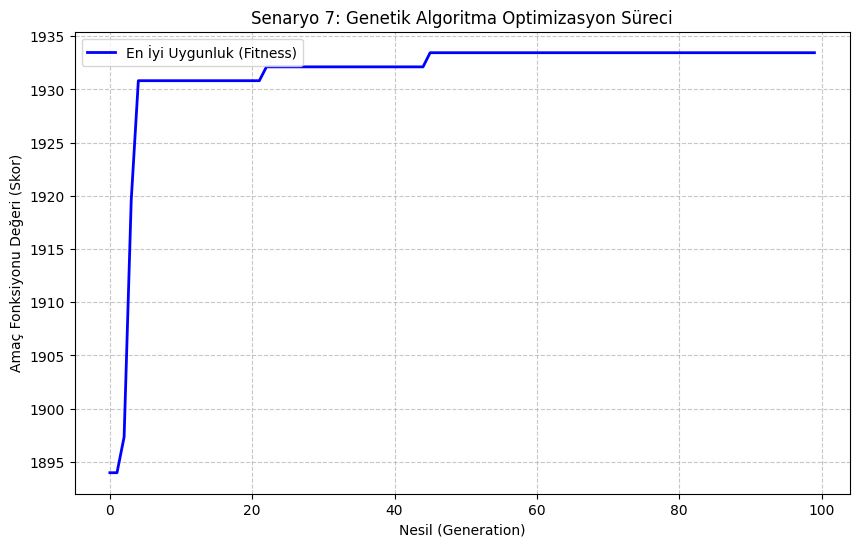

In [4]:
# --- GRAFİK ÇİZİMİ ---

plt.figure(figsize=(10, 6))
plt.plot(best_fitness_history, label='En İyi Uygunluk (Fitness)', color='blue', linewidth=2)
plt.title('Senaryo 7: Genetik Algoritma Optimizasyon Süreci')
plt.xlabel('Nesil (Generation)')
plt.ylabel('Amaç Fonksiyonu Değeri (Skor)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

### 5. Sonuçların Yorumlanması

**Senaryo 7** kapsamında yapılan optimizasyon çalışmasında:

1.  **Değişken Analizi:** Algoritma, $x_1$ ve $x_2$ değerlerini optimize ederken $x_1 x_2$ çarpımının pozitif etkisini kullanmaya çalışmış, ancak $x_1 + x_2 \le 100$ kısıtı nedeniyle sonsuza gidememiştir.
2.  **Kısıtların Etkisi:** En iyi çözüm genellikle toplam oranın 100'e çok yakın olduğu sınırlarda bulunmuştur. Bu durum, eldeki kaynağın (toplam %100 karışım) tamamının kullanıldığında verimin arttığını göstermektedir.
3.  **Başarım:** Grafik incelendiğinde, ilk nesillerde hızlı bir artış olduğu, sonrasında ise algoritmanın global maksimuma yakınsadığı görülmektedir. Kısıtlar (örneğin $x_1 \ge 25$) başarıyla sağlanmıştır.